# RAIL/estimation Tutorial Notebook

author: Sam Schmidt, Eric Charles, others...<br>
last run successfully: April 26, 2023<br>

(FIXME, workaround for bug in mixmod PDF triggered in new version of scipy)

This is a notebook demonstrating some of the features of the LSSTDESC `RAIL` package, namely the features of `estimation`.  `RAIL/estimation` is the interface for running production level photo-z codes within DESC.  There is a minimimal superclass that sets up some file paths and variable names, each specific photo-z code resides in a subclass with code-specific setup variables.<br>

RAIL is available at:<br>
https://github.com/LSSTDESC/RAIL<br>
and must be installed and included in your python path to work.  The LSSTDESC `qp` package that handles PDF files is also required, it is available at:<br>
https://github.com/LSSTDESC/qp<br>


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

We'll start by setting up the Rail data store.  RAIL uses [ceci](https://github.com/LSSTDESC/ceci), which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively.  This is a slight hack, and we will have some files appearing in the data store with the prefix "inprogress_" as they are stored in memory.  See the `RAIL/examples/goldenspike_examples/goldenspike.ipynb` example notebook for more details on the Data Store.

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

### Getting the list of available Estimators

RailStage knows about all of the sub-types of stages.  The are stored in the `RailStage.pipeline_stages` dict.  By looping through the values in that dict we can and asking if each one is a sub-class of `rail.estimation.estimator.CatEstimator` we can identify the available estimators that operator on catalog-like inputs.

In [4]:
for val in RailStage.pipeline_stages.values():
    if issubclass(val[0], rail.estimation.estimator.CatEstimator):
        print(val[0])

You should see a list of the available photo-z algorithms, as printed out above.  These are the names of the specific subclasses that invoke a particular method, and they are stored in the `rail.estimation.algos` subdirectory of RAIL.<br>

`randomPZ` is a very simple class that does not actually predict a meaningful photo-z, instead it produces a randomly drawn Gaussian for each galaxy.<br>
`trainZ` is our "pathological" estimator, it makes a PDF from a histogram of the training data and assigns that PDF to every galaxy.<br>
`simpleNN` uses `sklearn`'s neural network to predict a point redshift from the training data, then assigns a sigma width based on the redshift, another toy model example<br>
`FZBoost` is a fully functional photo-z algorith, implementing the FlexZBoost conditional density estimate method that was used in the PhotoZDC1 paper.<br>
`BPZ_lite` is a template-based code that outputs the posterior estimated given a specific template set and Bayesian prior. See Benitez (2000) for more details.<br>
`delightPZ` is a hybrid gaussian process/template-based code, see the [Delight](https://github.com/LSSTDESC/Delight) repo for more details.<br>
`KNearNeighPDF` is a simple implementation of a weighted k-nearest neighbor photo-z code, it stores each PDF as a weighted sum of Gaussians based on the distance from neighbors in color space.<br>
`PZFlowPDF` uses the same normalizing flow code [pzflow](https://github.com/jfcrenshaw/pzflow) used in the `creation` module to predict redshift PDFs.<br>

Each code should have two specific classes associated with it: one to train/inform using a set of training data, and a second to actually estimate the photo-z PDFs.  The naming pattern is `[name of code]` for the estimating class, and `Inform_[name of code]` for the training class, for example `FZBoost` and  `Inform_FZBoost`.  

The ceci code base will have us using a pattern where we will first run a `make_stage` method for the class in order to set up the ceci infrastructure.  Each `Inform_[name]` class will have a function called `inform` that actually performs the training.  Similarly, every `[photoz name]` class will have an `estimate` function to compute the PDFs.  We will show examples of this below.


## The code-specific parameters
Each photo-z code will have code-specific parameters necessary to initialize the code.  These values can be input on the command line, or passed in via a dictionary.<br>

Let's start with a very simple demonstration using `KNearNeighPDF`.  `KNearNeighPDF` is just `sklearn`'s nearest neighbor method run on the training data and set up within the RAIL interface.  It calculates a normalized weight for the K nearest neighbors based on their distance, and makes a PDF as a sum of K Gaussians, each at the redshift of the training galaxy with amplitude based on the distance weight, and a Gaussian width set by the user.  This is a toy model estimator, but it actually performs very well for representative data sets. There are configuration parameters for the names of columns, random seeds, etc... in KNearNeighPDF, but they are assigned sensible defaults, see the [KNearNeigh code](https://github.com/LSSTDESC/RAIL/blob/eac-dev/rail/estimation/algos/knnpz.py) for more details, but here is a minimal set to run:

In [5]:
knn_dict = dict(zmin=0.0, zmax=3.0, nzbins=301, trainfrac=0.75,
                sigma_grid_min=0.01, sigma_grid_max=0.07, ngrid_sigma=10,
                nneigh_min=3, nneigh_max=7, hdf5_groupname='photometry')

Here, `trainfrac` sets the amount of training data to use in training the algorithm.  The remaining fraction is used to validate two quantities, the width of the Gaussians used in constructing the PDF, and the number of neighbors used in each PDF.  The CDE Loss is computed on a grid of width and NN values, and the combination of width and NN with the lowest CDE loss is used.  `sigma_grid_min`, `sigma_grid_max`, and `ngrid_sigma` are used to specify the grid of sigma values to test, while `nneigh_min` and `nneigh_max` are the integer values between which we will check the loss.<br>
`zmin`, `zmax`, and `nzbins` are used to create a grid on which the CDE Loss is computed when minimizing the loss to find the best values for sigma and number of neighbors to use<br>

We will begin by training the algorithm, to to this we instantiate a rail object with a call to the base class.<br>
If any essential parameters are missing from the parameter dictionary, they will be set to default values:

In [6]:
from rail.estimation.algos.knnpz import Inform_KNearNeighPDF, KNearNeighPDF
pz_train = Inform_KNearNeighPDF.make_stage(name='inform_KNN', model='demo_knn.pkl', **knn_dict)

Now, let's load our training data, which is stored in hdf5 format.  We'll load it into the Data Store so that the ceci stages are able to access it.

In [7]:
from rail.core.utils import RAILDIR
trainFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

We need to train the KDTree, which is done with the `inform` function present in every RAIL/estimation code. The parameter `model` is the name that the trained model object will be saved in pickle format, in this case `demo_knn.pkl`.  In the future, rather than re-run a potentially time consuming training set, we can simply load this pickle file before we run the estimate stage.<br>

KNearNeighPDF.inform finds the best sigma and NNeigh and stores those along with the KDTree in the model.

In [8]:
%%time
pz_train.inform(training_data)

split into 7669 training and 2556 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03 and numneigh=7



Inserting handle into data store.  model_inform_KNN: inprogress_demo_knn.pkl, inform_KNN
CPU times: user 11.2 s, sys: 2.34 s, total: 13.5 s
Wall time: 13.5 s


We can now set up the main photo-z stage and run our algorithm on the data to produce simple photo-z estimates.  Note that we are loading the trained model that we computed from the inform stage:

In [9]:
pz = KNearNeighPDF.make_stage(name='KNN', hdf5_groupname='photometry',
                              model=pz_train.get_handle('model'))
results = pz.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_KNN: inprogress_output_KNN.hdf5, KNN
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating PZ PDF for rows 20,000 - 20,449


The output file is a dictionary containing the redshift PDFs and the mode of the PDFs.  The modes are stored in the "ancillary" data within qp, and can be accessed via:

In [10]:
zmode = results().ancil['zmode']

In [11]:
# The mode computation for mix_mod pdf is broken with the new scipy, but we can get easily
# get the peak of the largest contributor
whichone = np.argmax(results().dist.weights, axis=1)
zmode = np.array([means_[whichone_] for means_, whichone_ in zip(results().dist.means, whichone)])

Let's plot the redshift mode against the true redshifts to see how they look:

Text(0, 0.5, 'simple NN photo-z')

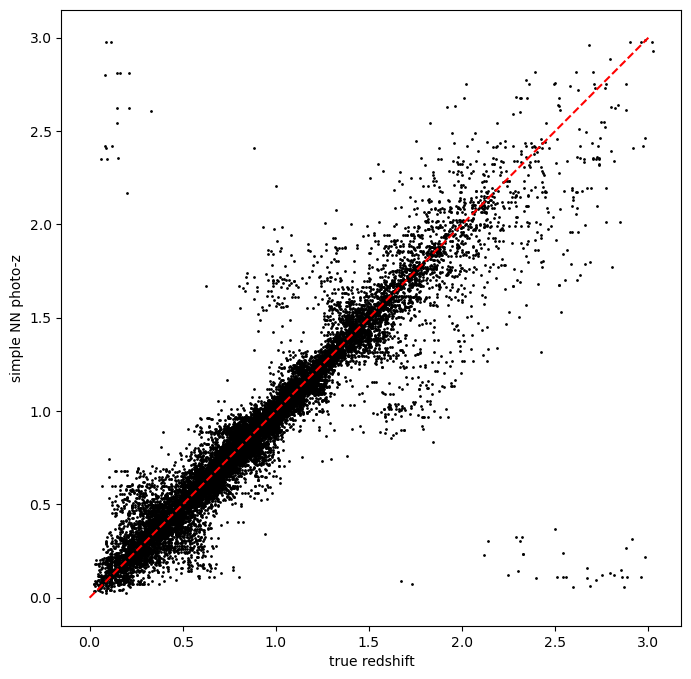

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'],zmode,s=1,c='k',label='simple NN mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("simple NN photo-z")

Not bad, given our very simple estimator.  For the PDFs, the simpleNN is storing a gridded parameterization where the PDF is evaluated at a fixed set of redshifts for each galaxy.  That grid is stored in `pz.zgrid`, and we'll need that to plot.  Remember that our simple Neural Net just estimated a point photo-z then assumed a Gaussian, so all PDFs will be of that simple form.  Let's plot an example pdf:

In [13]:
zgrid = np.linspace(0, 3., 301)

Text(0, 0.5, 'p(z)')

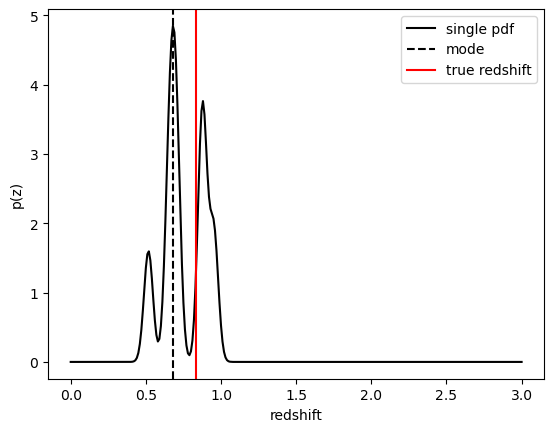

In [14]:
galid = 9529
single_gal = np.squeeze(results()[galid].pdf(zgrid))
single_zmode = zmode[galid]
truez = test_data()['photometry']['redshift'][galid]
plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmode,color='k', ls='--', label='mode')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")

We see that KNearNeigh PDFs do consist of a number of discrete Gaussians, and many have quite a bit of substructure.  This is a naive estimator, and some of these feature are likely spurious.

# FZBoost

That illustrates the basics, now let's try the `FZBoost` estimator.

`FZBoost` finds a conditional density estimate for each PDF via a set of weights for basis functions.  This can save space relative to a gridded parameterization, but it also sometimes leads to residual "bumps" in the PDF from the underlying parameterization.  For this reason, `FZBoost` has a post-processing stage where it "trims" (i.e. sets to zero) any "bumps" below a certain threshold.<br>

One of the dominant features seen in our PhotoZDC1 analysis of multiple photo-z codes (Schmidt, Malz et al. 2020) was that photo-z estimates were often, in general, overconfident or underconfident in their overall uncertainty in PDFs.  To remedy this, `FZBoost` has an additional post-processing step where it estimates a "sharpening" parameter that modulates the width of the PDFs.<br>

A portion of the training data is held in reserve to find best-fit values for both `bump_thresh` and `sharpening`, which we find by simply calculating the CDE loss for a grid of `bump_thresh` and `sharpening` values.<br>

We'll start with a dictionary of setup parameters for FZBoost, just as we had for simpleNN.  Some of the parameters are the same as in `simpleNN` above, `zmin`, `zmax`, `nzbins`.  However, FZBoost performs a more in depth training than simpleNN, and as such has more input parameters to control behavior.  These parameters are:<br>
`basis_system`: which basis system to use in the density estimate. The default is `cosine` but `fourier` is also an option<br>
`max_basis`: the maximum number of basis functions parameters to use for PDFs<br>
`regression_params`: a dictionary of options fed to `xgboost` that control the maximum depth and the `objective` function.  An update in `xgboost` means that `objective` should now be set to `reg:squarederror` for proper functioning.<br>
`trainfrac`: The fraction of the training data to use for training the density estimate.  The remaining galaxies will be used for validation of `bump_thresh` and `sharpening`.<br>
`bumpmin`: the minimum value to test in the `bump_thresh` grid<br>
`bumpmax`: the maximum value to test in the `bump_thresh` grid<br>
`nbump`: how many points to test in the `bump_thresh` grid<br>
`sharpmin`, `sharpmax`, `nsharp`: same as equivalent `bump_thresh` params, but for `sharpening` parameter<br>

In [15]:
fz_dict = dict(zmin=0.0, zmax=3.0, nzbins=301,
               trainfrac=0.75, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=35, basis_system='cosine',
               hdf5_groupname='photometry',
               regression_params={'max_depth': 8,'objective':'reg:squarederror'})
fz_modelfile = 'demo_FZB_model.pkl'

In [16]:
from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost
inform_pzflex = Inform_FZBoost.make_stage(name='inform_fzboost', model=fz_modelfile, **fz_dict)

We can now use this data to train our model using `FZBoost`'s inform() method.  `FZBoost` uses xgboost to determine a conditional density estimate model, and also fits a `bump_thresh` parameter that erases small peaks that are an artifact of the `cosine` parameterization.  It then finds a best fit `sharpen` parameter that modulates the peaks with a power law.<br>
We have `save_train` set to `True` in our `inform_options`, so this will save a pickled version of the best fit model to the file specified in `inform_options['modelfile']`, which is set above to `demo_FZB_model.pkl`.  We can use the same training data that we used for `simpleNN`.  `FZBoost` is a bit more sophisticated than `simpleNN`, so it will take a bit longer to train (note: it should take about 10-15 minutes on cori for the 10,000 galaxies in our demo sample):

In [17]:
%%time
inform_pzflex.inform(training_data)

stacking some data...
read in training data
fit the model...
[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.
[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.
[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.
[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


[16:13:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[16:13:50] WARN

## Loading a pre-trained model

That took quite a while to train! But, if we have an existing pretrained model, for example the one in the file `demo_FZB_model.pkl` we can skip this step in subsequent runs of estimate: thta is, we load this pickled model without having to repeat the training stage for this specific training data, and that should be much faster.

There are two supported model output representations, `interp` (default) and `flexzboost`. Using `interp` will store the output as interpolated y values for a given set of x values, using this approach will require much more storage space, but will generally be faster to work with. Using `flexzboost` will store the output weights from Flexcode. This results in a much smaller storage size on disk, but will also require additional computation time when working with the results. 

For additional comparisons of the approaches, see the documentation for `qp_flexzboost` here: https://qp-flexzboost.readthedocs.io/en/latest/source/performance_comparison.html

In [21]:
%%time
pzflex = FZBoost.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model'))

# For this notebook, we will use the default value of qp_representation as shown
# above due to the additional computation time that would be required in the
# later steps when working with the flexzboost representation.
# Below are two examples showing the explicit use of the qp_representation argument.
"""
pzflex = FZBoost.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model'),
                            qp_representation='interp')

pzflex = FZBoost.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model'),
                            qp_representation='flexzboost')
"""

CPU times: user 113 µs, sys: 33 µs, total: 146 µs
Wall time: 150 µs


"\npzflex = FZBoost.make_stage(name='fzboost', hdf5_groupname='photometry',\n                            model=inform_pzflex.get_handle('model'),\n                            qp_representation='interp')\n\npzflex = FZBoost.make_stage(name='fzboost', hdf5_groupname='photometry',\n                            model=inform_pzflex.get_handle('model'),\n                            qp_representation='flexzboost')\n"

Yes, only a few seconds.  So, if you are running an algorithm with a burdensome training requirement, saving a trained copy of the model for later repeated use can be a real time saver.

Now, let's compute photo-z's using with the `estimate` method.  

In [19]:
%%time
fzresults = pzflex.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating PZ PDF for rows 20,000 - 20,449
CPU times: user 17 s, sys: 2.05 s, total: 19 s
Wall time: 17.7 s


We can calculate the median and mode values of the PDFs and plot their distribution (the modes are already stored in the ancillary data, but here is an example of computing via qp as well):

In [20]:
fz_medians = fzresults().median()
fz_modes = fzresults().mode(grid=zgrid)

KeyboardInterrupt: 

In [ ]:
plt.hist(fz_medians, bins=np.linspace(-.005,3.005,101));
plt.xlabel("redshift")
plt.ylabel("Number")

We can plot an example PDF from the results file:

In [ ]:
galid = 9529
single_gal = np.squeeze(fzresults()[galid].pdf(zgrid))
single_zmedian = fz_medians[galid]
truez = test_data()['photometry']['redshift'][galid]
plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmedian,color='k', ls='--', label='median')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")

We can also plot a few point estimates to make sure our algorithm worked properly, we can compute the median of the PDF trivially and plot against true redshift:

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(test_data()['photometry']['redshift'],fz_modes,s=1,c='k')
plt.plot([0,3],[0,3],'r--')
plt.xlabel("true redshift")
plt.ylabel("photoz mode")
plt.title("median point estimate for FZBoost");

The results look very good! FZBoost is a mature algorithm, and with representative training data we see a very tight correlation with true redshift and few outliers.<br>